In [1]:
import pandas
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [2]:
#read data from google drive
data = pandas.read_csv("missing_data.csv")
  
data.head()

,country,age,is_mobile,source,converted
0,UK,33,0,Direct,0
1,NaN,38,1,Seo,0
2,NaN,46,0,Ads,0
3,NaN,48,1,Seo,0
4,Ireland,53,0,Ads,0


In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
  
data.describe(include='all')

,country,age,is_mobile,source,converted
count,95502,120704.000000,120704.000000,120704,120704.000000
unique,3,NaN,NaN,3,NaN
top,UK,NaN,NaN,Seo,NaN
freq,69626,NaN,NaN,59324,NaN
mean,NaN,44.575258,0.631006,NaN,0.169845
std,NaN,11.661944,0.482534,NaN,0.375498
min,NaN,17.000000,0.000000,NaN,0.000000
25%,NaN,36.000000,0.000000,NaN,0.000000
50%,NaN,44.000000,1.000000,NaN,0.000000
75%,NaN,53.000000,1.000000,NaN,0.000000


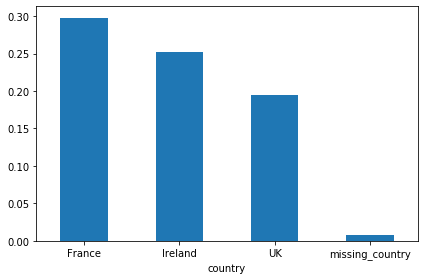

In [4]:
#Firstly, let's quickly check conversion rate of missing values vs non-missing values
#Group by country and check conversion rate
data.fillna("missing_country").groupby(['country'])['converted'].mean().plot.bar()
plt.xticks(rotation=0)
plt.show()

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
  
#set seed to be able to reproduce the results
np.random.seed(4684)
  
data_replace = data.copy()
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_replace, test_size = 0.34)
train = train.reset_index(drop=True).copy()
test =  test.reset_index(drop=True).copy()
  
#replace NAs with randomly selected countries according to the origianl country distribution
train['country'] = train['country'].fillna(pandas.Series(np.random.choice( train['country'].dropna() , size=len(train['country']) )))
test['country'] = test['country'].fillna(pandas.Series(np.random.choice( test['country'].dropna() , size=len(test['country']) )))
  
#create dummies
train = pandas.get_dummies(train, drop_first=True)
test =  pandas.get_dummies(test, drop_first=True)
  
#build the model. We will use a RF, but it is the same with any other model. We balance the weights to reduce class 1 errors
rf_replace_sampling = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_replace_sampling.fit(train.drop('converted', axis=1), train['converted'])
  
#and let's print test set confusion matrix
conf_matrix_sampling = pandas.DataFrame(confusion_matrix(test['converted'], rf_replace_sampling.predict(test.drop('converted', axis=1)), labels=[0, 1]))
conf_matrix_sampling

,0,1
0,23926,10233
1,2040,4841


In [7]:
#let's print model accuracy and class errors
class0_error = 1 - conf_matrix_sampling.loc[0,0]/(conf_matrix_sampling.loc[0,0]+conf_matrix_sampling.loc[0,1])
class1_error = 1 - conf_matrix_sampling.loc[1,1]/(conf_matrix_sampling.loc[1,0]+conf_matrix_sampling.loc[1,1])
  
pandas.DataFrame( {'accuracy': rf_replace_sampling.score(test.drop('converted', axis=1),test['converted']),
                         'class0_error' :[class0_error],
                         'class1_error' :[class1_error]
})

,accuracy,class0_error,class1_error
0,0.70095,0.29957,0.296469


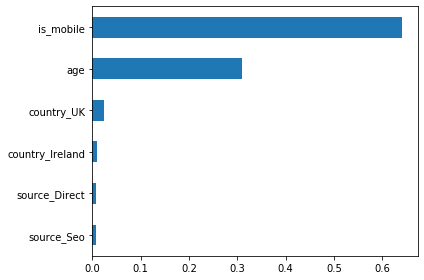

In [8]:
#variable importance
pandas.Series(rf_replace_sampling.feature_importances_, index=train.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [9]:
#replace missing values with "missing_country". Need to convert it to character and then back to factor
data['country'] = data['country'].fillna("missing_country")
  
#create dummy vars
data = pandas.get_dummies(data, drop_first=True)
  
#split test/train
#split into train and test to avoid overfitting
train_leave_NA, test_leave_NA = train_test_split(data, test_size = 0.34)
  
#build the model. We will use a RF, but it is the same with any other model. We slightly adjust the weights to reduce class 1 errors
rf_model_leave_NA = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_model_leave_NA.fit(train_leave_NA.drop('converted', axis=1), train_leave_NA['converted'])
#and let's print test set confusion matrix
conf_matrix_leave_NA = pandas.DataFrame(confusion_matrix(test_leave_NA['converted'], rf_model_leave_NA.predict(test_leave_NA.drop('converted', axis=1)), labels=[0, 1]))
conf_matrix_leave_NA

,0,1
0,25300,8680
1,1954,5106


In [10]:
#let's print model accuracy and class errors
class0_error_leave_NA = 1 - conf_matrix_leave_NA.loc[0,0]/(conf_matrix_leave_NA.loc[0,0]+conf_matrix_leave_NA.loc[0,1])
class1_error_leave_NA = 1 - conf_matrix_leave_NA.loc[1,1]/(conf_matrix_leave_NA.loc[1,0]+conf_matrix_leave_NA.loc[1,1])

pandas.DataFrame( {'accuracy_leave_NA': rf_model_leave_NA.score(test_leave_NA.drop('converted', axis=1),test_leave_NA['converted']),
                         'class0_error_leave_NA' :[class0_error_leave_NA],
                         'class1_error_leave_NA' :[class1_error_leave_NA]
})

,accuracy_leave_NA,class0_error_leave_NA,class1_error_leave_NA
0,0.740887,0.255444,0.276771


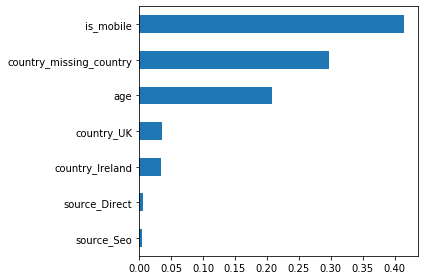

In [11]:
#variable importance
pandas.Series(rf_model_leave_NA.feature_importances_, index=train_leave_NA.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()